In [35]:
import pandas as pd
import numpy as np
import dateutil.parser as dparser
from datetime import date

In [36]:
# from google.colab import drive
# drive.mount('/content/drive/MyDrive/carpark prediction/')

In [37]:
weather = pd.read_csv("/content/drive/MyDrive/carpark prediction/meshed-sensor-type-1.csv")
parking = pd.read_csv("/content/drive/MyDrive/carpark prediction/on-street-parking-bay-sensors.csv")
rain = pd.read_csv("/content/drive/MyDrive/carpark prediction/IDCJAC0009_086338_1800_Data.csv")

In [38]:

parking[['lat','lon']] =parking["Location"].str.split(',',expand=True)
parking["Hour"] = parking["Status_Timestamp"].apply(lambda x : dparser.parse(x,fuzzy=True).time().hour)
parking["Weekday"] = parking["Status_Timestamp"].apply(lambda x : dparser.parse(x,fuzzy=True).date().weekday())
parking["date"] = parking["Status_Timestamp"].apply(lambda x : dparser.parse(x,fuzzy=True).date())

In [39]:
weather["date"] = weather["time"].apply(lambda x : dparser.parse(x,fuzzy=True).date())

In [40]:
rain["date"] = rain.apply(lambda r:date(year=r["Year"],month=r["Month"],day=r["Day"]),axis=1)

In [41]:
weather = pd.merge(rain,weather,how="left",on="date")
dataset = pd.merge(parking,weather,how="left",on="date")


In [42]:
dataset.isna().sum()

Lastupdated                                          0
Status_Timestamp                                     0
Zone_Number                                       1714
Status_Description                                   0
Parkingbay_ID                                        0
Location                                             0
lat                                                  0
lon                                                  0
Hour                                                 0
Weekday                                              0
date                                                 0
Product code                                         1
Bureau of Meteorology station number                 1
Year                                                 1
Month                                                1
Day                                                  1
Rainfall amount (millimetres)                        1
Period over which rainfall was measured (days)       1
Quality   

In [43]:
dataset["y"] = dataset["Status_Description"].apply(lambda x : 0 if x  == "Present" else 1 )

In [44]:
dataset = dataset.dropna(subset=["airtemp"])

In [45]:
weather.drop(["time","Product code","Bureau of Meteorology station number","Year","Month","Day",
              "Period over which rainfall was measured (days)","Quality","time","command",
              "precipitation","rtc","date","battery"],axis=1).columns.to_list()

['Rainfall amount (millimetres)',
 'solarpanel',
 'solar',
 'strikes',
 'windspeed',
 'winddirection',
 'gustspeed',
 'vapourpressure',
 'atmosphericpressure',
 'relativehumidity',
 'airtemp']

In [46]:
# + weather.drop(["time","rtc","date","battery"],axis=1).columns.to_list()
features = ["lat","lon","Hour","Weekday"] + weather.drop(["time","Product code","Bureau of Meteorology station number","Year","Month","Day",
              "Period over which rainfall was measured (days)","Quality","time","command",
              "precipitation","rtc","date","battery"],axis=1).columns.to_list()

In [47]:
features

['lat',
 'lon',
 'Hour',
 'Weekday',
 'Rainfall amount (millimetres)',
 'solarpanel',
 'solar',
 'strikes',
 'windspeed',
 'winddirection',
 'gustspeed',
 'vapourpressure',
 'atmosphericpressure',
 'relativehumidity',
 'airtemp']

In [48]:
X = dataset[features]
y = dataset["y"]

In [49]:
X.lat = pd.to_numeric(X.lat)

<ipython-input-49-5551987caed6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.lat = pd.to_numeric(X.lat)


In [50]:
X.lon = pd.to_numeric(X.lon)

<ipython-input-50-b56424cb3962>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.lon = pd.to_numeric(X.lon)


In [51]:
len(features)

15

<ipython-input-52-00ca24b1ad5a>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset[features + ["y"]].corr().round(2), annot=True, cmap='RdBu')


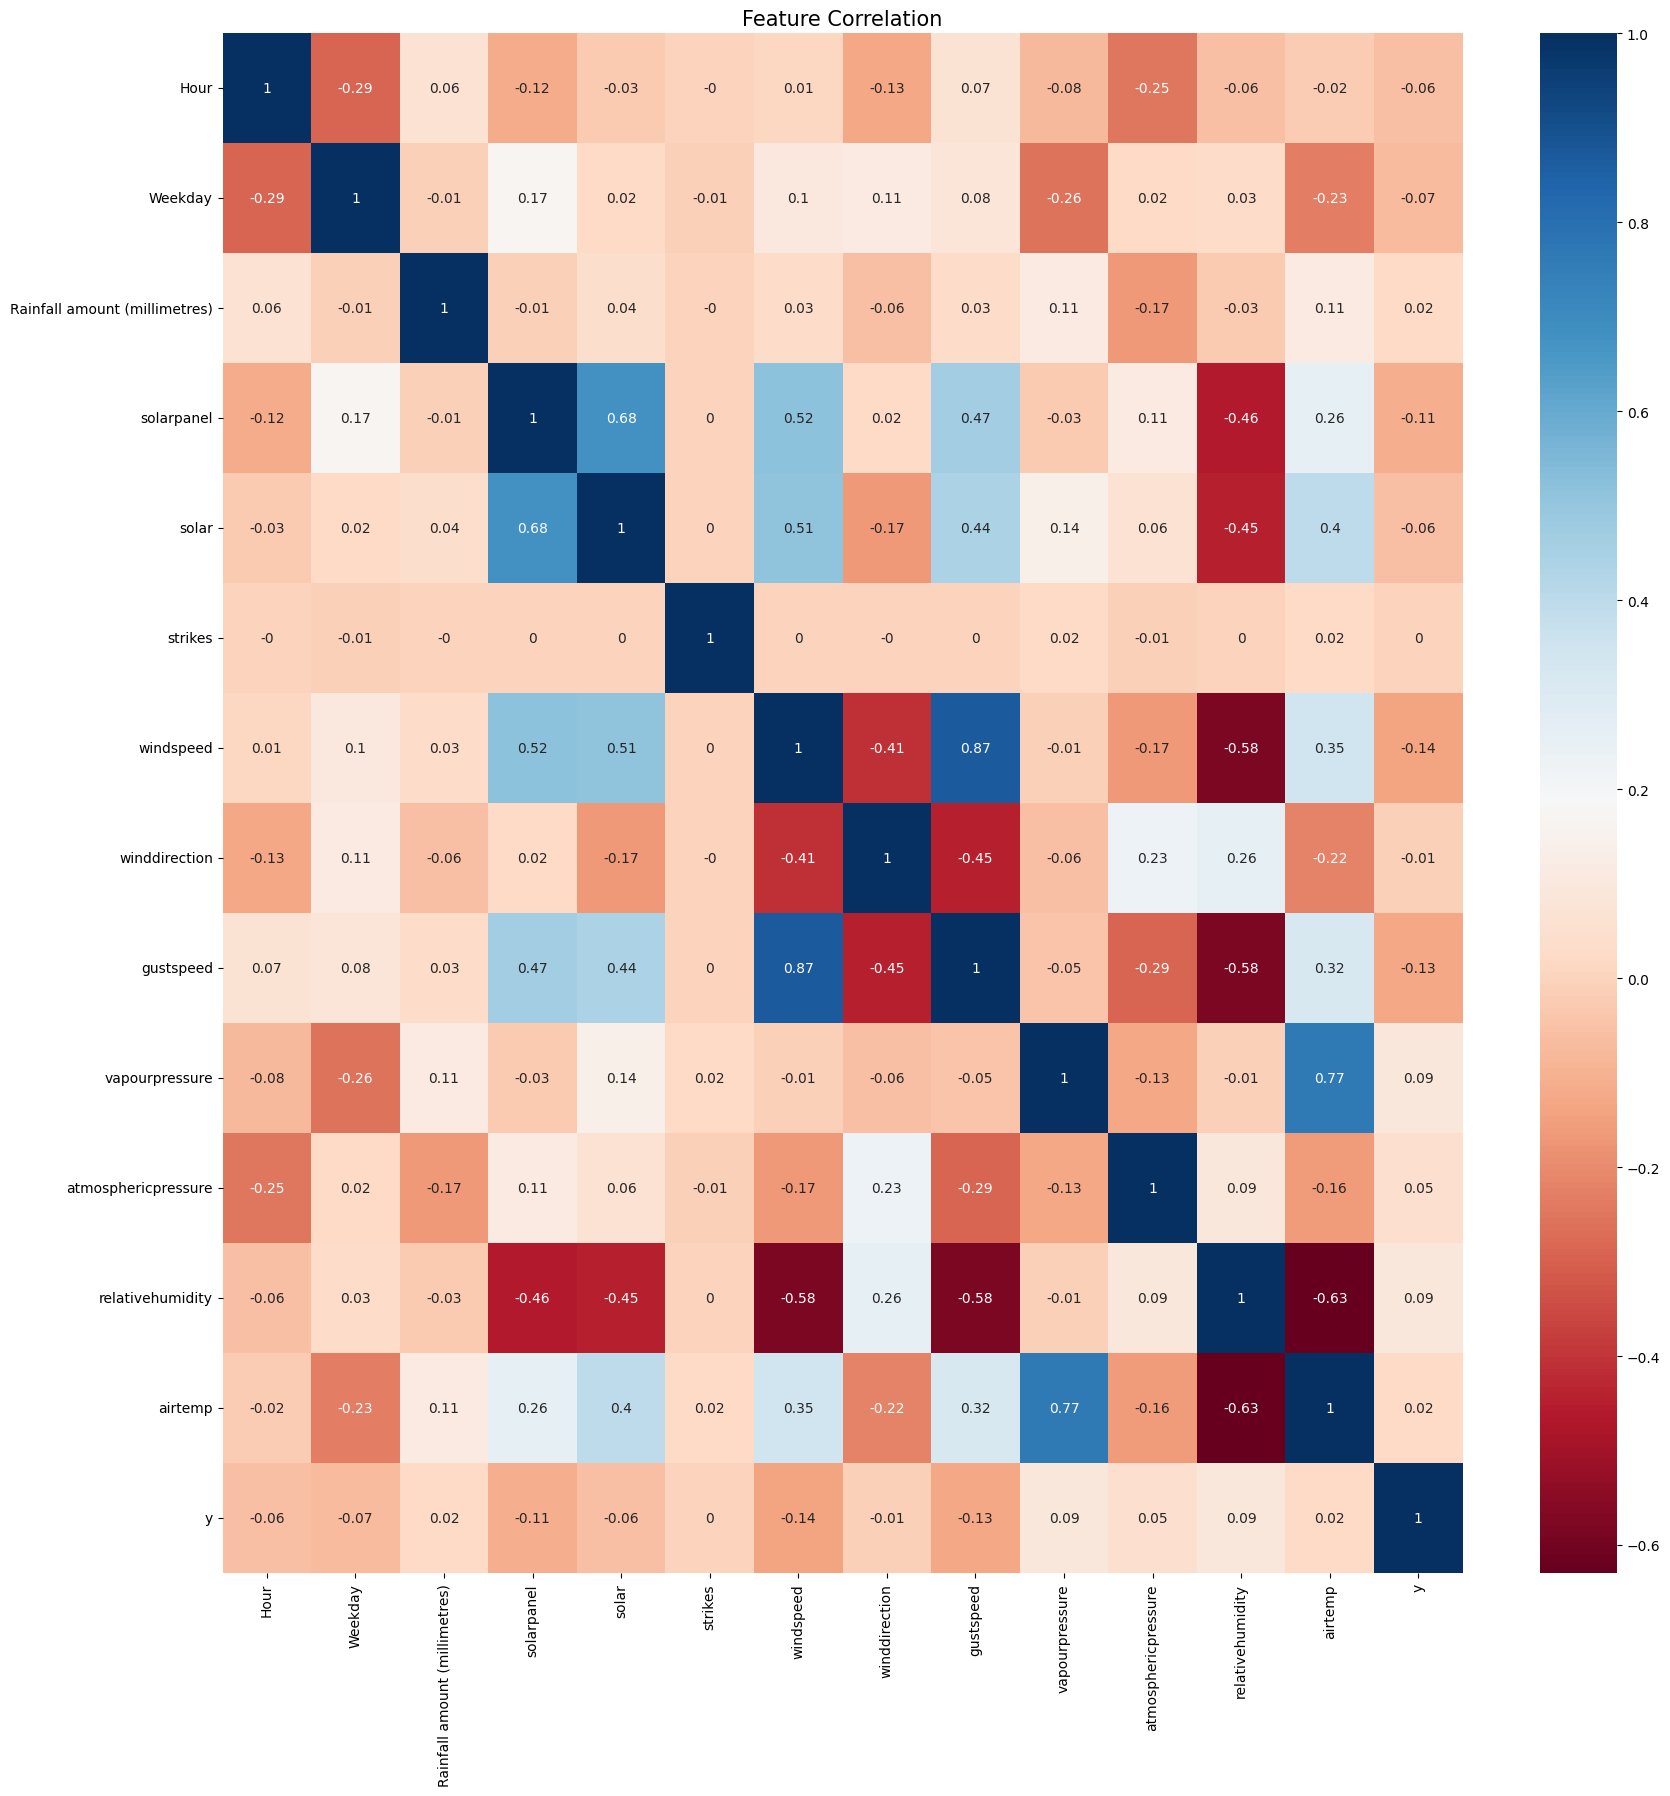

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Create a correlation heatmap using matplotlib and seaborn
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(dataset[features + ["y"]].corr().round(2), annot=True, cmap='RdBu')
highlight_color = 'blue'
ax.add_patch(Rectangle((0, 20), 21, 1, fill=False, edgecolor=highlight_color, lw=3))
ax.add_patch(Rectangle((20, 0), 1, 21, fill=False, edgecolor=highlight_color, lw=3))
plt.title("Feature Correlation", fontsize=15)

plt.show()

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)

In [54]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

x_train = scaler.transform(X_train.values)
x_test =  scaler.transform(X_test.values)
# x_train = X_train
# x_test = X_test

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [55]:
import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
# device = "cpu"
X_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)

X_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1).to(device)

cuda


In [56]:
from torch.utils.data import DataLoader ,TensorDataset

loaded_train = DataLoader(TensorDataset(X_train,y_train), batch_size=25, shuffle=True)
loaded_test = DataLoader(TensorDataset(X_test,y_test), batch_size=25, shuffle=True)

In [57]:
X_train.shape

torch.Size([121457, 15])

In [58]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(15, 255),
            nn.ReLU(),
            nn.Linear(255, 255),
            nn.ReLU(),
            nn.Linear(255, 255),
            nn.ReLU(),
            nn.Linear(255, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [59]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=255, bias=True)
    (1): ReLU()
    (2): Linear(in_features=255, out_features=255, bias=True)
    (3): ReLU()
    (4): Linear(in_features=255, out_features=255, bias=True)
    (5): ReLU()
    (6): Linear(in_features=255, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [60]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    correct_results_sum = (y_pred_tag == y_test).sum().float()

    # print(y_pred_tag == y_test)
    # print((y_pred_tag == y_test).sum().float())
    acc = correct_results_sum/y_test.shape[0]

    acc = torch.round(acc * 100)

    return acc

In [62]:
def train(dataloader, model, loss_fn, optimizer,losslist):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #compute loss
        pred = model(X)
        loss = loss_fn(pred, y)


        #backpropagtion
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:

            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [63]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct +=  binary_acc(pred,y)
    test_loss /= num_batches
    correct /= num_batches
    losslist.append(test_loss)
    print(f"Test Error: \n Accuracy: {(correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [64]:
epochs = 22
losslist = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loaded_train, model, loss_function, optimizer,losslist)
    test(loaded_test, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 0.707820  [    0/121457]
loss: 0.724406  [25000/121457]
loss: 0.546215  [50000/121457]
loss: 0.628230  [75000/121457]
loss: 0.628954  [100000/121457]
Test Error: 
 Accuracy: 69.9%, Avg loss: 0.587556 

Epoch 2
-------------------------------
loss: 0.535806  [    0/121457]
loss: 0.570642  [25000/121457]
loss: 0.445389  [50000/121457]
loss: 0.487448  [75000/121457]
loss: 0.448606  [100000/121457]
Test Error: 
 Accuracy: 73.9%, Avg loss: 0.537072 

Epoch 3
-------------------------------
loss: 0.543664  [    0/121457]
loss: 0.680679  [25000/121457]
loss: 0.465646  [50000/121457]
loss: 0.491882  [75000/121457]
loss: 0.524674  [100000/121457]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.507265 

Epoch 4
-------------------------------
loss: 0.397950  [    0/121457]
loss: 0.634231  [25000/121457]
loss: 0.597700  [50000/121457]
loss: 0.448893  [75000/121457]
loss: 0.505260  [100000/121457]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.496524 

Epoch 5


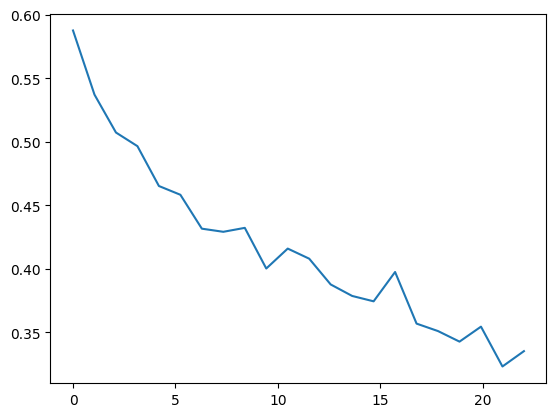

In [65]:
import matplotlib.pyplot as plt
step = np.linspace(0,len(losslist),len(losslist))
plt.plot(step,np.array(losslist))

In [66]:
losslist

[0.5875561931434973,
 0.5370722535767672,
 0.5072647270229128,
 0.4965237480070856,
 0.46517976948324546,
 0.45828112813609617,
 0.43160523067653916,
 0.4291413973373028,
 0.43224495553675996,
 0.4002493935694665,
 0.4159372567762563,
 0.40798876530226363,
 0.3877138079316528,
 0.3786746373331105,
 0.37443845535594006,
 0.39751632556227257,
 0.35690055931055986,
 0.3510229072453063,
 0.3427264615249487,
 0.35450601763563394,
 0.3231731922676166,
 0.3352375442047178]